In [1]:
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import warnings
import datetime
import requests
import time
import gc

warnings.filterwarnings("ignore")

In [2]:
country = "Norway"

# Loading and processing the datasets

In [3]:
tier_colors = {
    "Novice": "#1FA641",
    "Contributor": "#20BEFF",
    "Expert": "#8148FD",
    "Master": "#FF5C19",
    "Grandmaster": "#E5CF4A"
}

tier_icons = {
    'Grandmaster': '<img src="https://www.kaggle.com/static/images/tiers/grandmaster.svg" width="16" height="16" style="vertical-align: middle;">',
    'Master': '<img src="https://www.kaggle.com/static/images/tiers/master.svg" width="16" height="16" style="vertical-align: middle;">',
    'Expert': '<img src="https://www.kaggle.com/static/images/tiers/expert.svg" width="16" height="16" style="vertical-align: middle;">',
    'Contributor': '<img src="https://www.kaggle.com/static/images/tiers/contributor.svg" width="16" height="16" style="vertical-align: middle;">',
    'Novice': '<img src="https://www.kaggle.com/static/images/tiers/novice.svg" width="16" height="16" style="vertical-align: middle;">'
}

medal_icons = {
    'gold': '<img src="https://www.kaggle.com/static/images/medals/reflection-gold.svg" width="16" height="16" style="vertical-align: middle; margin-right: 3px;">',
    'silver': '<img src="https://www.kaggle.com/static/images/medals/reflection-silver.svg" width="16" height="16" style="vertical-align: middle; margin-right: 3px;">',
    'bronze': '<img src="https://www.kaggle.com/static/images/medals/reflection-bronze.svg" width="16" height="16" style="vertical-align: middle; margin-right: 3px;">'
}

In [4]:
users = pd.read_csv("/kaggle/input/meta-kaggle/Users.csv", parse_dates=["RegisterDate"])
users = users[users["Country"] == country]

achievements = pd.read_csv("/kaggle/input/meta-kaggle/UserAchievements.csv", parse_dates=["TierAchievementDate"])

data = pd.merge(users, achievements, left_on="Id", right_on="UserId", how="left")
data = data.drop(columns=["Id_x", "Id_y"])

del users, achievements
gc.collect()

0

In [5]:
current_year = datetime.datetime.now().year
ranks = list(tier_colors.keys())

data["TotalPoints"] = data.groupby("UserId")["Points"].transform("sum")
data["PerformanceTier"] = data["PerformanceTier"].map(lambda x: ranks[x])
data["Tier"] = data["Tier"].map(lambda x: ranks[x])
data["AvatarUrl"] = None

# Top users in Norway

In [6]:
unique_users = data["UserId"].nunique()
print(f"Number of unique users in {country}: {unique_users}")

Number of unique users in Norway: 2596


In [7]:
avatar_url_cache = {}

def get_avatar_url(row):
    user_id = row["UserId"]

    if user_id in avatar_url_cache.keys():
        return avatar_url_cache[user_id]
    
    postfixes = [ "kg.png", "kg.jpg", "kg.JPG", "fb.jpg", "kg.jpeg" , "kg.PNG", "gp.jpg", "gr.jpg" ]
    for postfix in postfixes:
        url = f"https://storage.googleapis.com/kaggle-avatars/images/{user_id}-{postfix}"
        res = requests.head(url)
        if res.status_code == 200:
            avatar_url_cache[user_id] = url
            return url
        time.sleep(1)
        
    url = "https://www.kaggle.com/static/images/profile/default-avatar.png"
    avatar_url_cache[user_id] = url
    return url

In [8]:
def display_top_n_users(data, n):
    df = data.sort_values(by="TotalPoints", ascending=False)[:4 * n]
    df["AvatarUrl"] = df.apply(lambda row: get_avatar_url(row), axis=1)
  
    html_style = '''
    <style>
      .achievement-table {
        border-collapse: collapse;
        width: 100%;
        font-family: Arial, sans-serif;
        margin-top: 20px;
      }
      .achievement-table th, .achievement-table td {
        padding: 12px;
        text-align: left;
        border-bottom: 1px solid #ddd;
        vertical-align: middle;
      }
      .achievement-table th {
        background-color: #f2f2f2;
        font-weight: bold;
      }
      .achievement-table tr:hover {
        background-color: #f5f5f5;
      }
      .avatar-img {
        width: 48px;
        height: 48px;
        border-radius: 50%;
        object-fit: cover;
      }
      .achievement-icon {
        width: 24px;
        height: 24px;
        display: block;
        margin: 0 auto;
      }
      .centered {
        text-align: center;
      }
      .points {
        font-weight: bold;
        text-align: right;
      }
    </style>
    '''
    
    html = html_style + '<table class="achievement-table"><thead><tr>'
    columns = ['Avatar', 'Username', 'Display Name', 'Competitions', 'Datasets', 'Scripts', 'Discussion', 'Total Points']
    
    for col in columns:
        html += f'<th>{col}</th>'
    html += '</tr></thead><tbody>'
    
    unique_users = df[['UserId', 'UserName', 'DisplayName', 'AvatarUrl', 'TotalPoints']].drop_duplicates('UserId')
    for _, user in unique_users.iterrows():
        user_id = user['UserId']
        avatar_html = f'<img src="{user["AvatarUrl"]}" class="avatar-img" alt="{user["DisplayName"]}">'
        
        html += f'''
        <tr>
          <td>{avatar_html}</td>
          <td><a href="https://www.kaggle.com/{user["UserName"]}" target="_blank">{user["UserName"]}</a></td>
          <td>{user["DisplayName"]}</td>
        '''
        
        categories = ['Competitions', 'Datasets', 'Scripts', 'Discussion']
        for category in categories:
            user_achievement = df[(df['UserId'] == user_id) & (df['AchievementType'] == category)]
            
            if not user_achievement.empty:
                tier = user_achievement.iloc[0]['Tier']
                tier_icon = tier_icons[tier].replace('width="16" height="16"', 'class="achievement-icon"')
                html += f'<td class="centered">{tier_icon}</td>'
            else:
                html += '<td class="centered">-</td>'
        
        html += f'<td class="points">{user["TotalPoints"]:,}</td>'
        html += '</tr>'
    
    html += '</tbody></table>'
    
    return display(HTML(html))

In [9]:
display_top_n_users(data, 10)

Avatar,Username,Display Name,Competitions,Datasets,Scripts,Discussion,Total Points
,abhishek,Abhishek Thakur,,,,,"9,369"
,habedi,Hassan Abedi,,,,,"8,773"
,ravaghi,Mahdi Ravaghi,,,,,"8,558"
,olemagnushiback,Ole-Magnus Høiback,,,,,"6,642"
,tvdwiele,Tom Van de Wiele,,,,,"6,324"
,strutsefar,Ruben Gundersen,,,,,"3,510"
,thomasbrekkunnvik,Thomas Brekk Unnvik,,,,,"2,552"
,mhmdsab,Mohammed Sabry,,,,,"2,423"
,icecuber,icecuber,,,,,"2,049"
,gali1eo,Z.F,,,,,"1,231"


# Top users in each category

In [10]:
def display_tier_counts(data, category):  
    df = data[data["AchievementType"] == category].groupby("Tier").size().reset_index(name="Count").sort_values(by="Count", ascending=True)  
    html_style = '''
    <style>
      .tier-table {
        border-collapse: collapse;
        width: 100%;
        font-family: Arial, sans-serif;
        margin-top: 20px;
      }
      .tier-table th, .tier-table td {
        padding: 12px;
        text-align: center;
        border: 1px solid #ddd;
      }
      .tier-cell {
        display: flex;
        align-items: center;
        justify-content: center;
      }
      .tier-icon {
        width: 32px;
        height: 32px;
        margin-right: 12px;
      }
      .tier-text {
        display: flex;
        flex-direction: column;
        align-items: center;
        text-align: center;
      }
      .tier-count {
        font-size: 20px;
        font-weight: bold;
      }
      .tier-name {
        font-size: 14px;
        display: block;
      }
    </style>
    '''
    
    html = html_style + '<table class="tier-table"><tr>'
    
    for tier in tier_icons.keys():
        count = df[df['Tier'] == tier]['Count'].values[0] if tier in df['Tier'].values else 0
        
        tier_icon_large = tier_icons[tier].replace('width="16" height="16"', 'class="tier-icon"')
        
        html += f'''
        <td>
          <div class="tier-cell">
            {tier_icon_large}
            <div class="tier-text">
              <span class="tier-count">{count}</span>
              <span class="tier-name">{tier}s</span>
            </div>
          </div>
        </td>
        '''
    
    html += '</tr></table>'
    
    return display(HTML(html))

In [11]:
def display_leaderboard(data, category, n):
    df = data[data["AchievementType"] == category].sort_values(by="CurrentRanking")[:n]
    df = df[["UserId", "UserName", "DisplayName", "Tier", "CurrentRanking", "HighestRanking", "TotalGold", "TotalSilver", "TotalBronze", "AvatarUrl"]]
    df["AvatarUrl"] = df.apply(lambda row: get_avatar_url(row), axis=1)
    
    html_style = '''
    <style>
      table {
        border-collapse: collapse;
        width: 100%;
        font-family: Arial, sans-serif;
      }
      th, td {
        padding: 8px;
        text-align: left;
        border-bottom: 1px solid #ddd;
        vertical-align: middle;
      }
      th {
        background-color: #f2f2f2;
        font-weight: bold;
      }
      tr:hover {background-color: #f5f5f5;}
      .avatar-img {
        width: 40px;
        height: 40px;
        border-radius: 50%;
        object-fit: cover;
      }
      .medal-count {
        min-width: 20px;
        display: inline-block;
        text-align: left;
        vertical-align: middle;
      }
      .medal-container {
        display: flex;
        align-items: center;
        height: 24px;
      }
      .medal-item {
        display: flex;
        align-items: center;
        margin-right: 10px;
        min-width: 42px;
      }
    </style>
    '''
    
    html_table = html_style + '<table>\n  <thead>\n    <tr>\n'
    headers = ['Avatar', 'Username', 'Display Name', 'Tier', 'Current Ranking', 'Highest Ranking', 'Medals']
    for header in headers:
        html_table += f'      <th>{header}</th>\n'
    
    html_table += '    </tr>\n  </thead>\n  <tbody>\n'
    
    for _, row in df.iterrows():        
        tier_icon = tier_icons.get(row['Tier'], '⭐')
        
        avatar_html = f'<img src={row["AvatarUrl"]} class="avatar-img" alt="{row["DisplayName"]}">'
        
        medal_html = f'''
        <div class="medal-container">
          <div class="medal-item">
            {medal_icons['gold']}<span class="medal-count">{row['TotalGold']}</span>
          </div>
          <div class="medal-item">
            {medal_icons['silver']}<span class="medal-count">{row['TotalSilver']}</span>
          </div>
          <div class="medal-item">
            {medal_icons['bronze']}<span class="medal-count">{row['TotalBronze']}</span>
          </div>
        </div>
        '''
        
        html_table += f'''    <tr>
      <td>{avatar_html}</td>
      <td><a href="https://www.kaggle.com/{row["UserName"]}" target="_blank">{row["UserName"]}</a></td>
      <td>{row['DisplayName']}</td>
      <td>{tier_icon}</td>
      <td>{int(max(0, row['CurrentRanking']))}</td>
      <td>{int(max(0, row['HighestRanking']))}</td>
      <td>{medal_html}</td>
    </tr>\n'''
    
    html_table += '  </tbody>\n</table>'
    
    return display(HTML(html_table))

## Competitions

In [12]:
display_tier_counts(data, "Competitions")

2 Grandmasters,4 Masters,20 Experts,307 Contributors,2263 Novices


In [13]:
display_leaderboard(data, "Competitions", 10)

Avatar,Username,Display Name,Tier,Current Ranking,Highest Ranking,Medals
,habedi,Hassan Abedi,,967,735,1 5 3
,abhishek,Abhishek Thakur,,1038,3,21 40 23
,tvdwiele,Tom Van de Wiele,,1407,16,7 1 0
,strutsefar,Ruben Gundersen,,2391,1993,0 2 0
,mhmdsab,Mohammed Sabry,,3194,1517,0 3 3
,icecuber,icecuber,,3571,20,2 0 0
,gali1eo,Z.F,,4608,3179,0 0 2
,keegil,Kjetil Åmdal-Sævik,,7069,628,0 6 1
,fatall,Murat Korkmaz,,7238,663,0 2 2
,terje62,Terje,,7313,921,0 1 1


## Notebooks

In [14]:
display_tier_counts(data, "Scripts")

1 Grandmasters,3 Masters,11 Experts,318 Contributors,2263 Novices


In [15]:
display_leaderboard(data, "Scripts", 10)

Avatar,Username,Display Name,Tier,Current Ranking,Highest Ranking,Medals
,ravaghi,Mahdi Ravaghi,,56,56,5 13 40
,abhishek,Abhishek Thakur,,58,1,68 27 29
,mistag,Geir Drange,,1871,109,4 7 21
,mohaiminul101,Mohaiminul Islam,,3459,126,1 11 3
,abrahamanderson,Abraham Anderson,,3550,345,0 3 18
,habedi,Hassan Abedi,,4359,2071,0 1 5
,bjoernjostein,Bjorn,,4372,832,0 2 14
,snippsy,Erik,,5463,197,1 3 8
,kaaveland,rkaveland,,5593,423,1 1 9
,rinichristy,Rini Christy,,5759,1319,0 0 7


## Discussions

In [16]:
display_tier_counts(data, "Discussion")

1 Grandmasters,0 Masters,13 Experts,319 Contributors,2263 Novices


In [17]:
display_leaderboard(data, "Discussion", 10)

Avatar,Username,Display Name,Tier,Current Ranking,Highest Ranking,Medals
,ravaghi,Mahdi Ravaghi,,89,88,15 7 206
,abhishek,Abhishek Thakur,,146,2,153 151 919
,tvdwiele,Tom Van de Wiele,,1558,23,16 28 170
,mohaiminul101,Mohaiminul Islam,,1911,370,6 3 165
,snippsy,Erik,,2471,230,3 5 155
,bjoernjostein,Bjorn,,2920,570,0 3 106
,mhmdsab,Mohammed Sabry,,2927,764,0 2 61
,mistag,Geir Drange,,3185,1079,0 2 72
,abrahamanderson,Abraham Anderson,,3229,988,0 0 77
,fatall,Murat Korkmaz,,3985,255,2 2 48


## Datasets

In [18]:
display_tier_counts(data, "Datasets")

1 Grandmasters,0 Masters,5 Experts,327 Contributors,2263 Novices


In [19]:
display_leaderboard(data, "Datasets", 10)

Avatar,Username,Display Name,Tier,Current Ranking,Highest Ranking,Medals
,abhishek,Abhishek Thakur,,163,2,14 7 27
,bjoernjostein,Bjorn,,1260,277,0 0 10
,ravaghi,Mahdi Ravaghi,,1383,1382,0 0 3
,mohaiminul101,Mohaiminul Islam,,1876,36,0 5 1
,rinichristy,Rini Christy,,2332,555,0 0 4
,vlbthambawita,VT,,2452,1128,0 0 3
,yilmaz,Yilmaz,,0,0,0 0 0
,vegardryan,Vegard Ryan,,0,0,0 0 0
,indexhtml,Lars E,,0,0,0 0 0
,nilsolvegillund,Nils Olve Gillund,,0,0,0 0 0


# User registrations over time

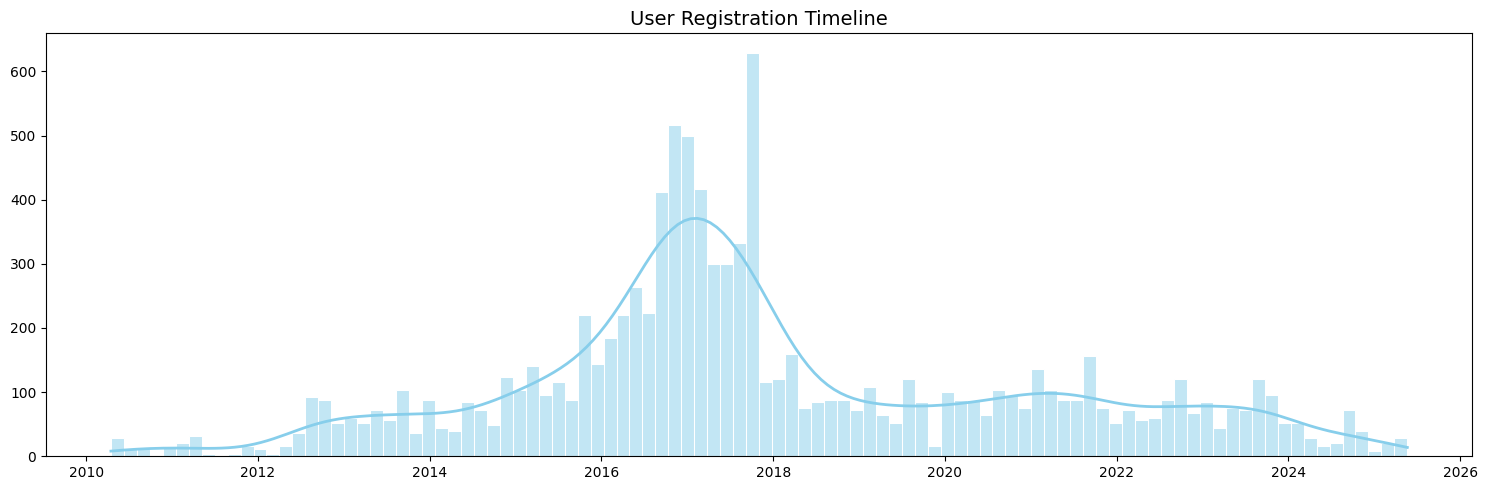

In [20]:
plt.figure(figsize=(15, 5))
sns.histplot(
    data=data,
    x="RegisterDate", 
    bins=100, 
    color="skyblue", 
    edgecolor="white", 
    kde=True,
    line_kws={"linewidth": 2, "color": "navy"}
)
plt.title("User Registration Timeline", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

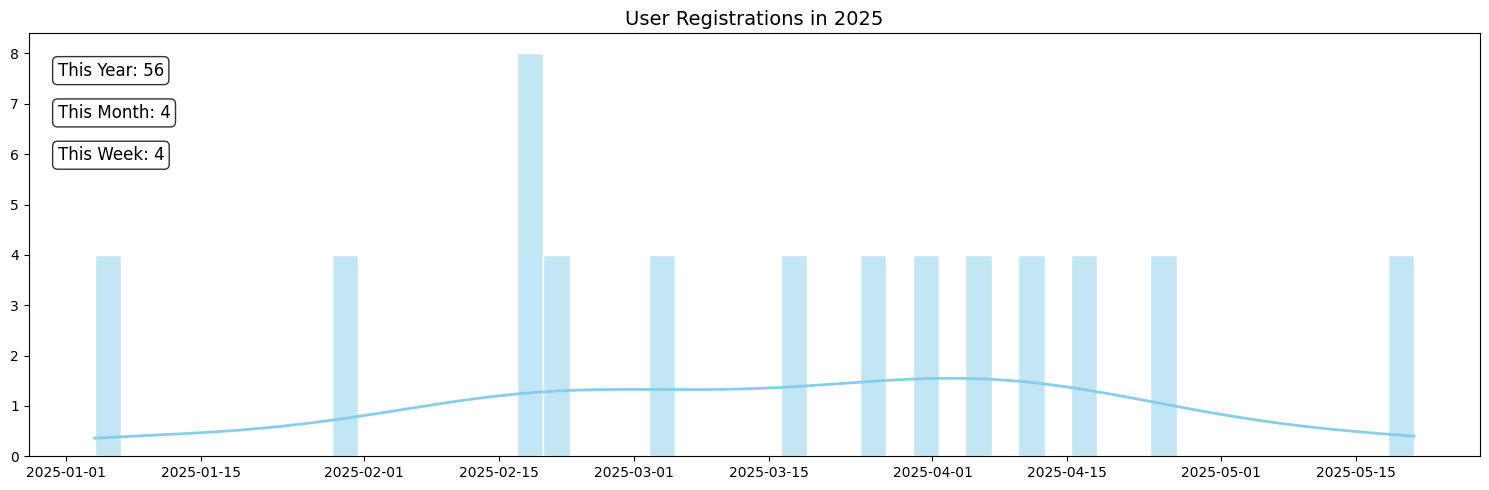

In [21]:
now = datetime.datetime.now()
current_year = now.year
current_month = now.month
current_week = now.isocalendar()[1]

current_year_registrations = data[data["RegisterDate"].dt.year == current_year]
current_month_registrations = data[(data["RegisterDate"].dt.year == current_year) & (data["RegisterDate"].dt.month == current_month)]
current_week_registrations = data[(data["RegisterDate"].dt.year == current_year) & (data["RegisterDate"].dt.isocalendar().week == current_week)]

year_count = len(current_year_registrations)
month_count = len(current_month_registrations)
week_count = len(current_week_registrations)

plt.figure(figsize=(15, 5))
sns.histplot(
    data=current_year_registrations,
    x="RegisterDate", 
    bins=50, 
    color="skyblue", 
    edgecolor="white", 
    kde=True,
    line_kws={"linewidth": 2, "color": "navy"}
)

plt.annotate(
    f"This Year: {year_count}", 
    xy=(0.02, 0.9), 
    xycoords="axes fraction", 
    fontsize=12, 
    bbox=dict(
        boxstyle="round,pad=0.3", 
        facecolor="white", 
        alpha=0.8
    )
)

plt.annotate(
    f"This Month: {month_count}", 
    xy=(0.02, 0.8), 
    xycoords="axes fraction", 
    fontsize=12, 
    bbox=dict(
        boxstyle="round,pad=0.3", 
        facecolor="white", 
        alpha=0.8
    )
)

plt.annotate(
    f"This Week: {week_count}", 
    xy=(0.02, 0.7), 
    xycoords="axes fraction", 
    fontsize=12, 
    bbox=dict(
        boxstyle="round,pad=0.3",
        facecolor="white", 
        alpha=0.8
    )
)
plt.title(f"User Registrations in {current_year}", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

# Time to achieve a rank

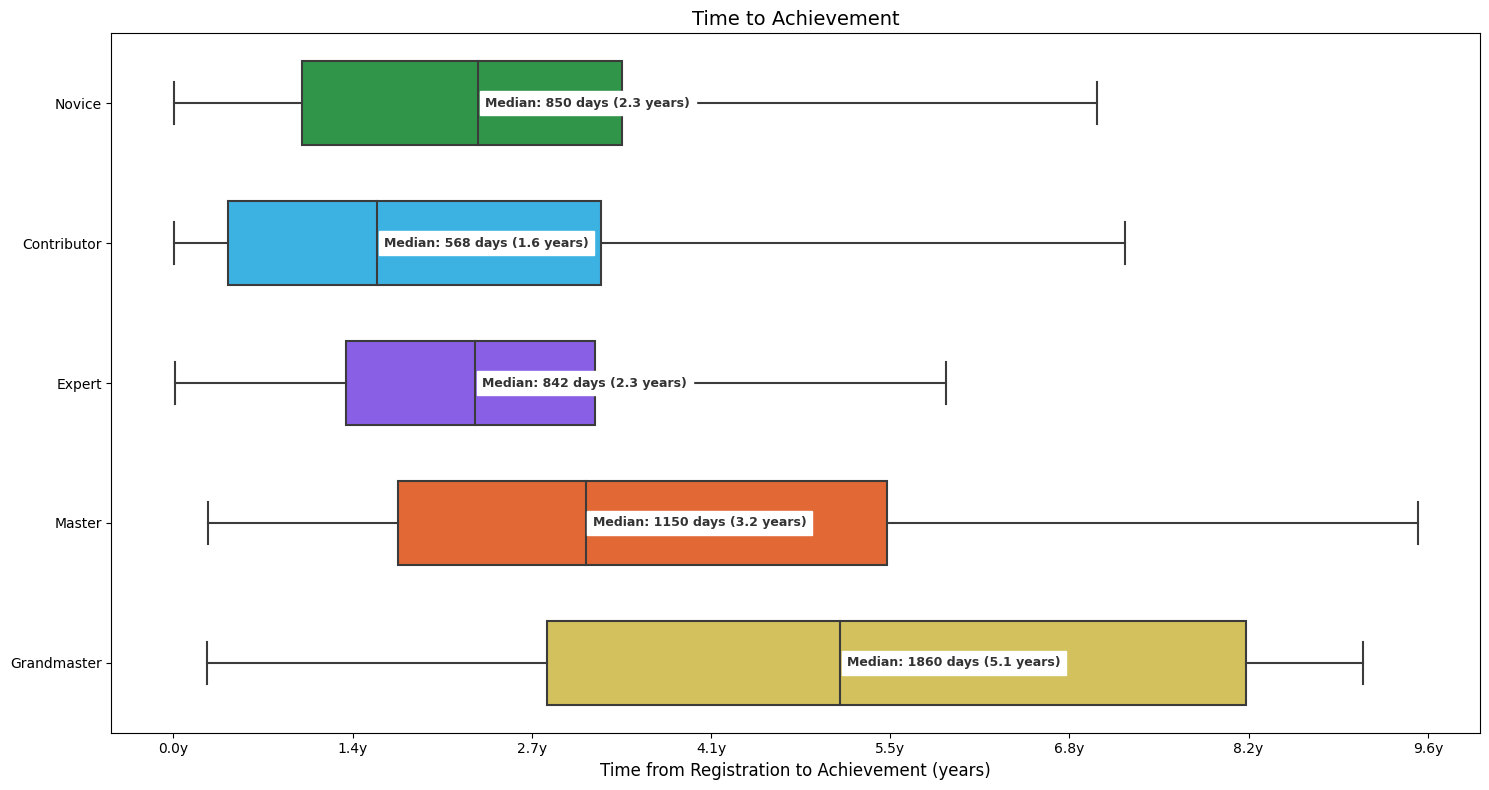

In [22]:
from matplotlib.ticker import FuncFormatter
def days_to_years(x, pos):
    return f"{x/365:.1f}y"


data["DaysToAchievement"] = (data["TierAchievementDate"] - data["RegisterDate"]).dt.days

plt.figure(figsize=(15, 8))
ax = sns.boxplot(
    y="PerformanceTier",
    x="DaysToAchievement", 
    data=data[data["DaysToAchievement"] > 0],
    order=ranks,
    palette=tier_colors,
    width=0.6,
    showfliers=False
)

ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))
for i, tier in enumerate(ranks):
    tier_data = data[(data["PerformanceTier"] == tier) & (data["DaysToAchievement"] > 0)]
    if len(tier_data) > 0:
        median_days = tier_data["DaysToAchievement"].median()
        median_years = median_days / 365
        plt.text(
            median_days + 20,
            i,
            f"Median: {median_days:.0f} days ({median_years:.1f} years)",
            va="center",
            fontweight="bold",
            fontsize=9,
            backgroundcolor="white",
            alpha=0.8
        )

plt.title("Time to Achievement", fontsize=14)
plt.ylabel("")
plt.xlabel("Time from Registration to Achievement (years)", fontsize=12)
plt.tight_layout()
plt.show()